## 一、多因子模型搭建

### （1）引入需要用到的库

In [19]:
import tushare as ts #股票基本数据相关库
import numpy as np #科学计算相关库
import pandas as pd #科学计算相关库
import matplotlib.pyplot as plt # 绘图相关库
import talib # 股票衍生变量数据相关库
from sklearn.ensemble import RandomForestClassifier #集成学习随机森林分类决策树
from sklearn.metrics import accuracy_score #准确度评分函数
import warnings
warnings.filterwarnings("ignore") # 忽略警告信息，警告非报错，不影响代码执行

### （2）获取数据

In [9]:
# 1.股票基本数据获取
df = ts.get_k_data('000002',start='2015-01-01',end='2019-12-31')
df = df.set_index('date')  # 设置日期为索引
df.head()

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


,open,close,high,low,volume,code
date,,,,,,
2015-01-05,7.20,7.72,8.10,7.03,6560835.0,000002
2015-01-06,7.41,7.17,7.80,6.86,3346346.0,000002
2015-01-07,7.07,7.04,7.31,6.81,2642051.0,000002
2015-01-08,7.13,6.40,7.18,6.27,2639394.0,000002
2015-01-09,6.35,6.26,7.03,6.10,3294584.0,000002


In [11]:
# 2.简单衍生变量构造
df['close-open'] = (df['close'] - df['open'])/df['open']
df['high-low'] = (df['high'] - df['low'])/df['low']

df['pre_close'] = df['close'].shift(1)  # 该列所有往下移一行形成昨日收盘价
df['price_change'] = df['close']-df['pre_close']
df['p_change'] = (df['close']-df['pre_close'])/df['pre_close']*100
df.head()

,open,close,high,low,volume,code,close-open,high-low,pre_close,price_change,p_change
date,,,,,,,,,,,
2015-01-05,7.20,7.72,8.10,7.03,6560835.0,000002,0.072222,0.152205,NaN,NaN,NaN
2015-01-06,7.41,7.17,7.80,6.86,3346346.0,000002,-0.032389,0.137026,7.72,-0.55,-7.124352
2015-01-07,7.07,7.04,7.31,6.81,2642051.0,000002,-0.004243,0.073421,7.17,-0.13,-1.813110
2015-01-08,7.13,6.40,7.18,6.27,2639394.0,000002,-0.102384,0.145136,7.04,-0.64,-9.090909
2015-01-09,6.35,6.26,7.03,6.10,3294584.0,000002,-0.014173,0.152459,6.40,-0.14,-2.187500


In [12]:
# 3.移动平均线相关数据构造
df['MA5'] = df['close'].rolling(5).mean()
df['MA10'] = df['close'].rolling(10).mean()
df.dropna(inplace=True)  # 删除空值
df.head()

,open,close,high,low,volume,code,close-open,high-low,pre_close,price_change,p_change,MA5,MA10
date,,,,,,,,,,,,,
2015-01-16,6.58,6.33,6.58,6.20,2129475.0,000002,-0.037994,0.061290,6.58,-0.25,-3.799392,6.126,6.522
2015-01-19,5.31,4.98,5.71,4.98,3603625.0,000002,-0.062147,0.146586,6.33,-1.35,-21.327014,5.936,6.248
2015-01-20,5.01,5.16,5.41,4.87,2914688.0,000002,0.029940,0.110883,4.98,0.18,3.614458,5.792,6.047
2015-01-21,5.14,5.86,6.01,4.91,3555294.0,000002,0.140078,0.224033,5.16,0.70,13.565891,5.782,5.929
2015-01-22,5.83,6.39,6.46,5.73,3224727.0,000002,0.096055,0.127400,5.86,0.53,9.044369,5.744,5.928


In [17]:
# 4.通过Ta_lib库构造衍生变量
df['RSI'] = talib.RSI(df['close'], timeperiod=12)  # 相对强弱指标
df['MOM'] = talib.MOM(df['close'], timeperiod=5)  # 动量指标
df['EMA12'] = talib.EMA(df['close'], timeperiod=12)  # 12日指数移动平均线
df['EMA26'] = talib.EMA(df['close'], timeperiod=26)  # 26日指数移动平均线
df['MACD'], df['MACDsignal'], df['MACDhist'] = talib.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)  # MACD值
df.dropna(inplace=True)  # 删除空值
df.head()

,open,close,high,low,volume,code,close-open,high-low,pre_close,price_change,p_change,MA5,MA10,RSI,MOM,EMA12,EMA26,MACD,MACDsignal,MACDhist
date,,,,,,,,,,,,,,,,,,,,
2015-06-15,8.29,7.76,8.31,7.72,2741810.0,000002,-0.063932,0.076425,8.29,-0.53,-6.393245,8.196,8.152,49.461841,-1.13,8.027497,7.675655,0.351379,0.387363,-0.035984
2015-06-16,7.73,7.19,7.74,7.07,2668429.0,000002,-0.069858,0.094767,7.76,-0.57,-7.345361,7.940,8.110,42.797249,-1.28,7.898652,7.639681,0.258579,0.361606,-0.103027
2015-06-17,7.23,7.39,7.41,6.91,2186123.0,000002,0.022130,0.072359,7.19,0.20,2.781641,7.752,8.063,45.602833,-0.94,7.820398,7.621186,0.198880,0.329061,-0.130181
2015-06-18,7.45,6.99,7.63,6.96,2625411.0,000002,-0.061745,0.096264,7.39,-0.40,-5.412720,7.524,7.982,41.194594,-1.14,7.692644,7.574431,0.117932,0.286835,-0.168903
2015-06-19,6.81,6.36,7.02,6.31,2185683.0,000002,-0.066079,0.112520,6.99,-0.63,-9.012876,7.138,7.780,35.327126,-1.93,7.487622,7.484474,0.002911,0.230050,-0.227139


### （3）特征变量和目标变量提取

In [20]:
X = df[['close', 'volume', 'close-open', 'MA5', 'MA10', 'high-low', 'RSI', 'MOM', 'EMA12', 'MACD', 'MACDsignal', 'MACDhist']]
y = np.where(df['price_change'].shift(-1)> 0, 1, -1) #np.where(判断条件,满足条件的赋值,不满足条件的赋值)

### （4）划分训练集和测试集

训练集与测试集的划分要按照时间序列划分，而不是像之前利用train_test_split()函数进行划分。原因在于股票价格的变化趋势具有时间性，如果我们随机
划分，则会破坏时间性特征，因为是根据当天数据来预测下一天的股价涨跌情况，而不是任意一天的股票数据来预测下一天的股价涨跌情况。

In [21]:
X_length = X.shape[0]  # shape属性获取X的行数和列数，shape[0]即表示行数 
split = int(X_length * 0.9)

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

### （5）模型搭建

决策树的最大深度max_depth设置为3，即每个决策树最多只有3层；弱学习器（即决策树模型）的个数n_estimators设置为10，即该随机森林中共有10个决策
树；叶子节点的最小样本数min_samples_leaf设置为10，即如果叶子节点的样本数小于10则停止分裂；随机状态参数random_state的作用是使每次运行结果
保持一致，这里设置的数字1没有特殊含义，可以换成其他数字。

In [24]:
model = RandomForestClassifier(max_depth=3,  n_estimators=10, min_samples_leaf=10, random_state=1)
model.fit(X_train, y_train) #fit()函数训练模型

RandomForestClassifier(max_depth=3, min_samples_leaf=10, n_estimators=10,
                       random_state=1)

## 二、模型的使用与评估

### （1）预测下一天的股价涨跌情况

In [25]:
y_pred = model.predict(X_test)
print(y_pred)

[ 1  1  1  1  1 -1 -1  1  1 -1  1 -1  1  1  1  1  1 -1  1  1  1 -1 -1 -1
 -1 -1  1 -1 -1 -1 -1  1 -1 -1  1 -1  1  1  1  1  1  1  1  1 -1  1 -1 -1
  1 -1  1 -1 -1 -1 -1  1  1  1  1 -1  1  1 -1 -1 -1  1 -1  1  1 -1  1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1 -1 -1 -1 -1  1  1 -1 -1 -1
 -1 -1]


In [26]:
#汇总预测值y_pred和测试集的实际值y_test
a = pd.DataFrame()
a['预测值'] = list(y_pred)
a['实际值'] = list(y_test)
a.head()

,预测值,实际值
0,1,-1
1,1,1
2,1,-1
3,1,-1
4,1,1


In [27]:
# 查看预测概率
y_pred_proba = model.predict_proba(X_test)
y_pred_proba[0:5]

array([[0.45578883, 0.54421117],
       [0.37734473, 0.62265527],
       [0.49311827, 0.50688173],
       [0.45578883, 0.54421117],
       [0.43269607, 0.56730393]])

### （2）模型准确度评估

In [29]:
from sklearn.metrics import accuracy_score
score = accuracy_score(y_pred, y_test)
print(score)

0.5204081632653061


### （3）分析特征变量的特征重要性

In [30]:
model.feature_importances_

array([0.11546223, 0.05772797, 0.05312257, 0.        , 0.09852535,
       0.09452718, 0.07019172, 0.11095536, 0.11011501, 0.11024076,
       0.09098303, 0.08814882])

In [32]:
features = X.columns
importances = model.feature_importances_

a = pd.DataFrame()
a['特征'] = features
a['特征重要性'] = importances
a = a.sort_values('特征重要性', ascending=False)
a

,特征,特征重要性
0,close,0.115462
7,MOM,0.110955
9,MACD,0.110241
8,EMA12,0.110115
4,MA10,0.098525
5,high-low,0.094527
10,MACDsignal,0.090983
11,MACDhist,0.088149
6,RSI,0.070192
1,volume,0.057728


## 三、参数调优

In [33]:
from sklearn.model_selection import GridSearchCV # 网格搜索合适的超参数
parameters = {'n_estimators':[5, 10, 20], 'max_depth':[2, 3, 4, 5], 'min_samples_leaf':[5, 10, 20, 30]} # 指定分类器中参数的范围
new_model = RandomForestClassifier(random_state=1) # 构建新模型
#设置cv参数为6，表示交叉验证6次；设置模型评估标准scoring参数为'accuracy'，即以准确度作为评估标准，如果设置成'roc_auc'则表示以ROC曲线的AUC值作为评估标准
grid_search = GridSearchCV(new_model, parameters, cv=6, scoring='accuracy')  

In [35]:
grid_search.fit(X_train, y_train) #传入训练集数据b
grid_search.best_params_  # 输出参数的最优值

{'max_depth': 2, 'min_samples_leaf': 5, 'n_estimators': 10}

## 四、收益回测曲线绘制

前面已经评估了模型的预测准确度，不过在商业实战中，我们更关心它的收益回测曲线（又称为净值曲线），也就是看根据搭建的模型获得的结果是否比不利用模型获得的结果更好。

In [36]:
X_test['prediction'] = model.predict(X_test)
X_test['p_change'] = (X_test['close'] - X_test['close'].shift(1)) / X_test['close'].shift(1)

X_test['origin'] = (X_test['p_change'] + 1).cumprod()
X_test['strategy'] = (X_test['prediction'].shift(1) * X_test['p_change'] + 1).cumprod()

X_test[['strategy', 'origin']].tail()

,strategy,origin
date,,
2019-12-25,1.223410,1.157681
2019-12-26,1.185878,1.193196
2019-12-27,1.190981,1.188062
2019-12-30,1.166531,1.212452
2019-12-31,1.141418,1.238554


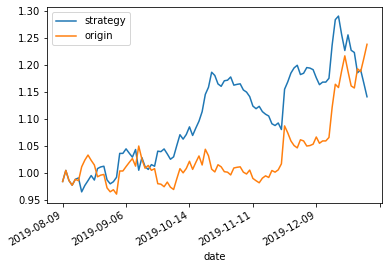

In [37]:
# 将收益率删除空值后进行可视化，并设置x轴刻度自动倾斜
X_test[['strategy', 'origin']].dropna().plot()
plt.gcf().autofmt_xdate()
plt.show()

图中上方的曲线为根据模型得到的收益率曲线，下方的曲线为股票本身的收益率曲线，可以看到，利用模型得到的收益还是不错的。